# Batch Validation

The purpose of this notebook is to use a variety of methods to check for batch effects.

In [53]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
import scib_metrics as sm
import seaborn as sns
import statsmodels.formula.api as smf
import umap
import warnings

from contextlib import redirect_stdout
from matplotlib.colors import to_rgba
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")

## Data Import and Overview

In [3]:
# Read the data
data = pd.read_csv("/data/processed/tabular/cells_znorm.csv", index_col=0)


# Load timepoint associations
treatment_map = pd.read_csv("/data/metadata/treatment_mapping.csv", index_col=0)
cell_meta = pd.read_csv("/data/metadata/cells_metadata.csv", index_col=0)

cell_meta = cell_meta.reset_index().merge(treatment_map, how="left", on="treatment_id").set_index("cell_id")

The following shows an overview of the wells and which treatments they correspond to, as well as how many cells came from each well.

In [4]:
display(
    cell_meta
    .groupby(["well", "treatment_id", "treatment"])
    .size()
    .reset_index(name='cell_count')
    .sort_values("treatment_id")
    [["well", "treatment", "cell_count"]]
    )


,well,treatment,cell_count
0,B02,control,2343
10,C02,control,1983
1,B03,2day,7096
2,B04,5day,4455
3,B05,9day,3395
11,C06,11day,1620
4,B06,11day,1794
5,B07,13day,1586
12,C07,13day,1815
6,B08,15day,1531


## UMAP

Starting off with the UMAP so we get a general idea of what the raw dimensionally reduced data looks like and how treatments and wells map onto the projection.

Now perform UMAP:

In [5]:
reducer = umap.UMAP(random_state=416)

umap_data = data.values

embedding = reducer.fit_transform(umap_data)
embedding

array([[ 9.657295 ,  8.520238 ],
       [ 9.8047285,  8.356604 ],
       [ 5.049511 , 10.486411 ],
       ...,
       [-2.8633459,  1.5592083],
       [ 2.4207788,  2.1866114],
       [ 9.578608 ,  8.80853  ]], dtype=float32)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

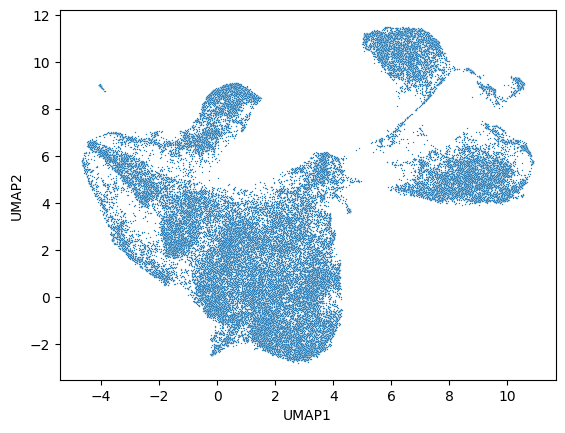

In [6]:
embedding_cp = pd.DataFrame({
    "cell_id": data.index,
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1]})

embedding_cp.set_index("cell_id")

embedding_final = embedding_cp.merge(cell_meta, how='left', left_index=True, right_index=True)

sns.scatterplot(data=embedding_final, x='UMAP1', y='UMAP2', s=1)

Text(0.5, 1.0, 'Colored by Treatment')

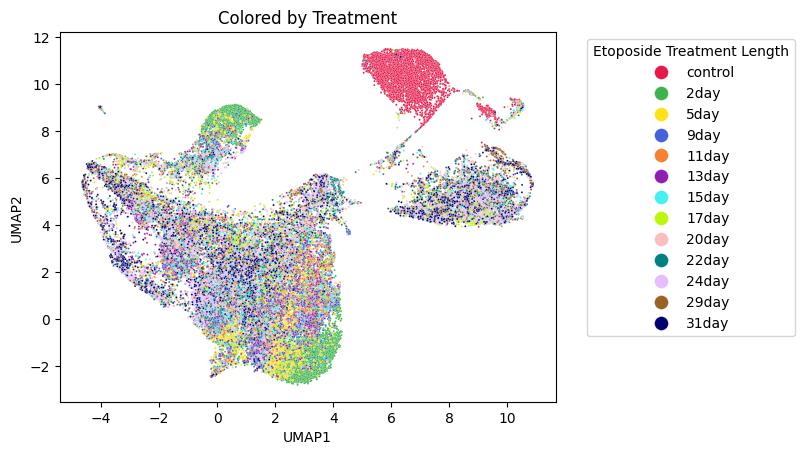

In [7]:
# Color by treatment

treatment_palette = [
    '#e6194b',  # strong red
    '#3cb44b',  # vivid green
    '#ffe119',  # bright yellow
    '#4363d8',  # strong blue
    '#f58231',  # orange
    '#911eb4',  # purple
    '#46f0f0',  # cyan
    '#bcf60c',  # lime
    '#fabebe',  # pink
    '#008080',  # teal
    '#e6beff',  # lavender
    '#9a6324',  # brown
    '#000075'   # navy 
]

sns.scatterplot(data=embedding_final, x='UMAP1', y='UMAP2', hue='treatment', palette=treatment_palette, s=2)
plt.legend(title="Etoposide Treatment Length", loc="upper left", markerscale=7,
           bbox_to_anchor=(1.05,1))
plt.title(label="Colored by Treatment")

Text(0.5, 1.0, 'Colored by Well')

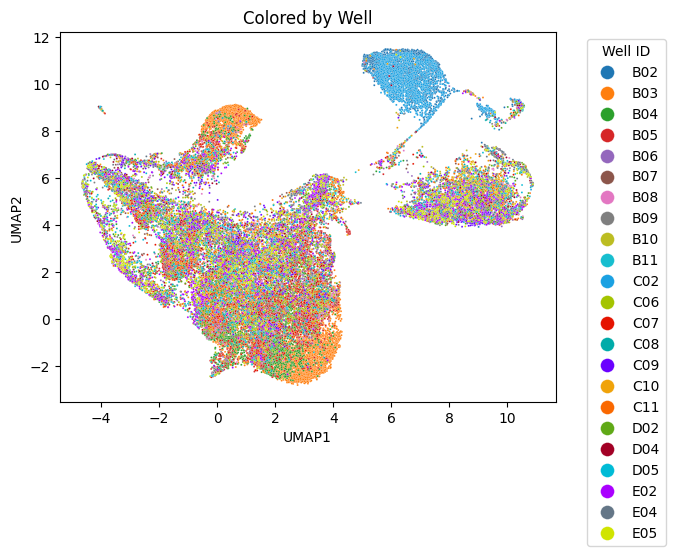

In [8]:
well_palette = [
    "#1F77B4",  # Deep Blue
    "#FF7F0E",  # Orange
    "#2CA02C",  # Green
    "#D62728",  # Red
    "#9467BD",  # Purple
    "#8C564B",  # Brown
    "#E377C2",  # Pink
    "#7F7F7F",  # Gray
    "#BCBD22",  # Olive
    "#17BECF",  # Cyan
    "#1BA1E2",  # Sky Blue
    "#A4C400",  # Lime
    "#E51400",  # Magenta
    "#00ABA9",  # Teal
    "#6A00FF",  # Indigo
    "#F0A30A",  # Gold
    "#FA6800",  # Coral
    "#60A917",  # Mint
    "#A20025",  # Wine
    "#00BBD6",  # Turquoise
    "#AA00FF",  # Violet
    "#647687",  # Steel
    "#D0E400",  # Chartreuse
]

sns.scatterplot(data=embedding_final,  x='UMAP1', y='UMAP2', hue='well', 
                palette=well_palette, s=2)
plt.legend(title="Well ID", loc="upper left", markerscale=7,
           bbox_to_anchor=(1.05,1))
plt.title(label="Colored by Well")

For easier viewing, I'm going to show how each well maps onto the UMAP.

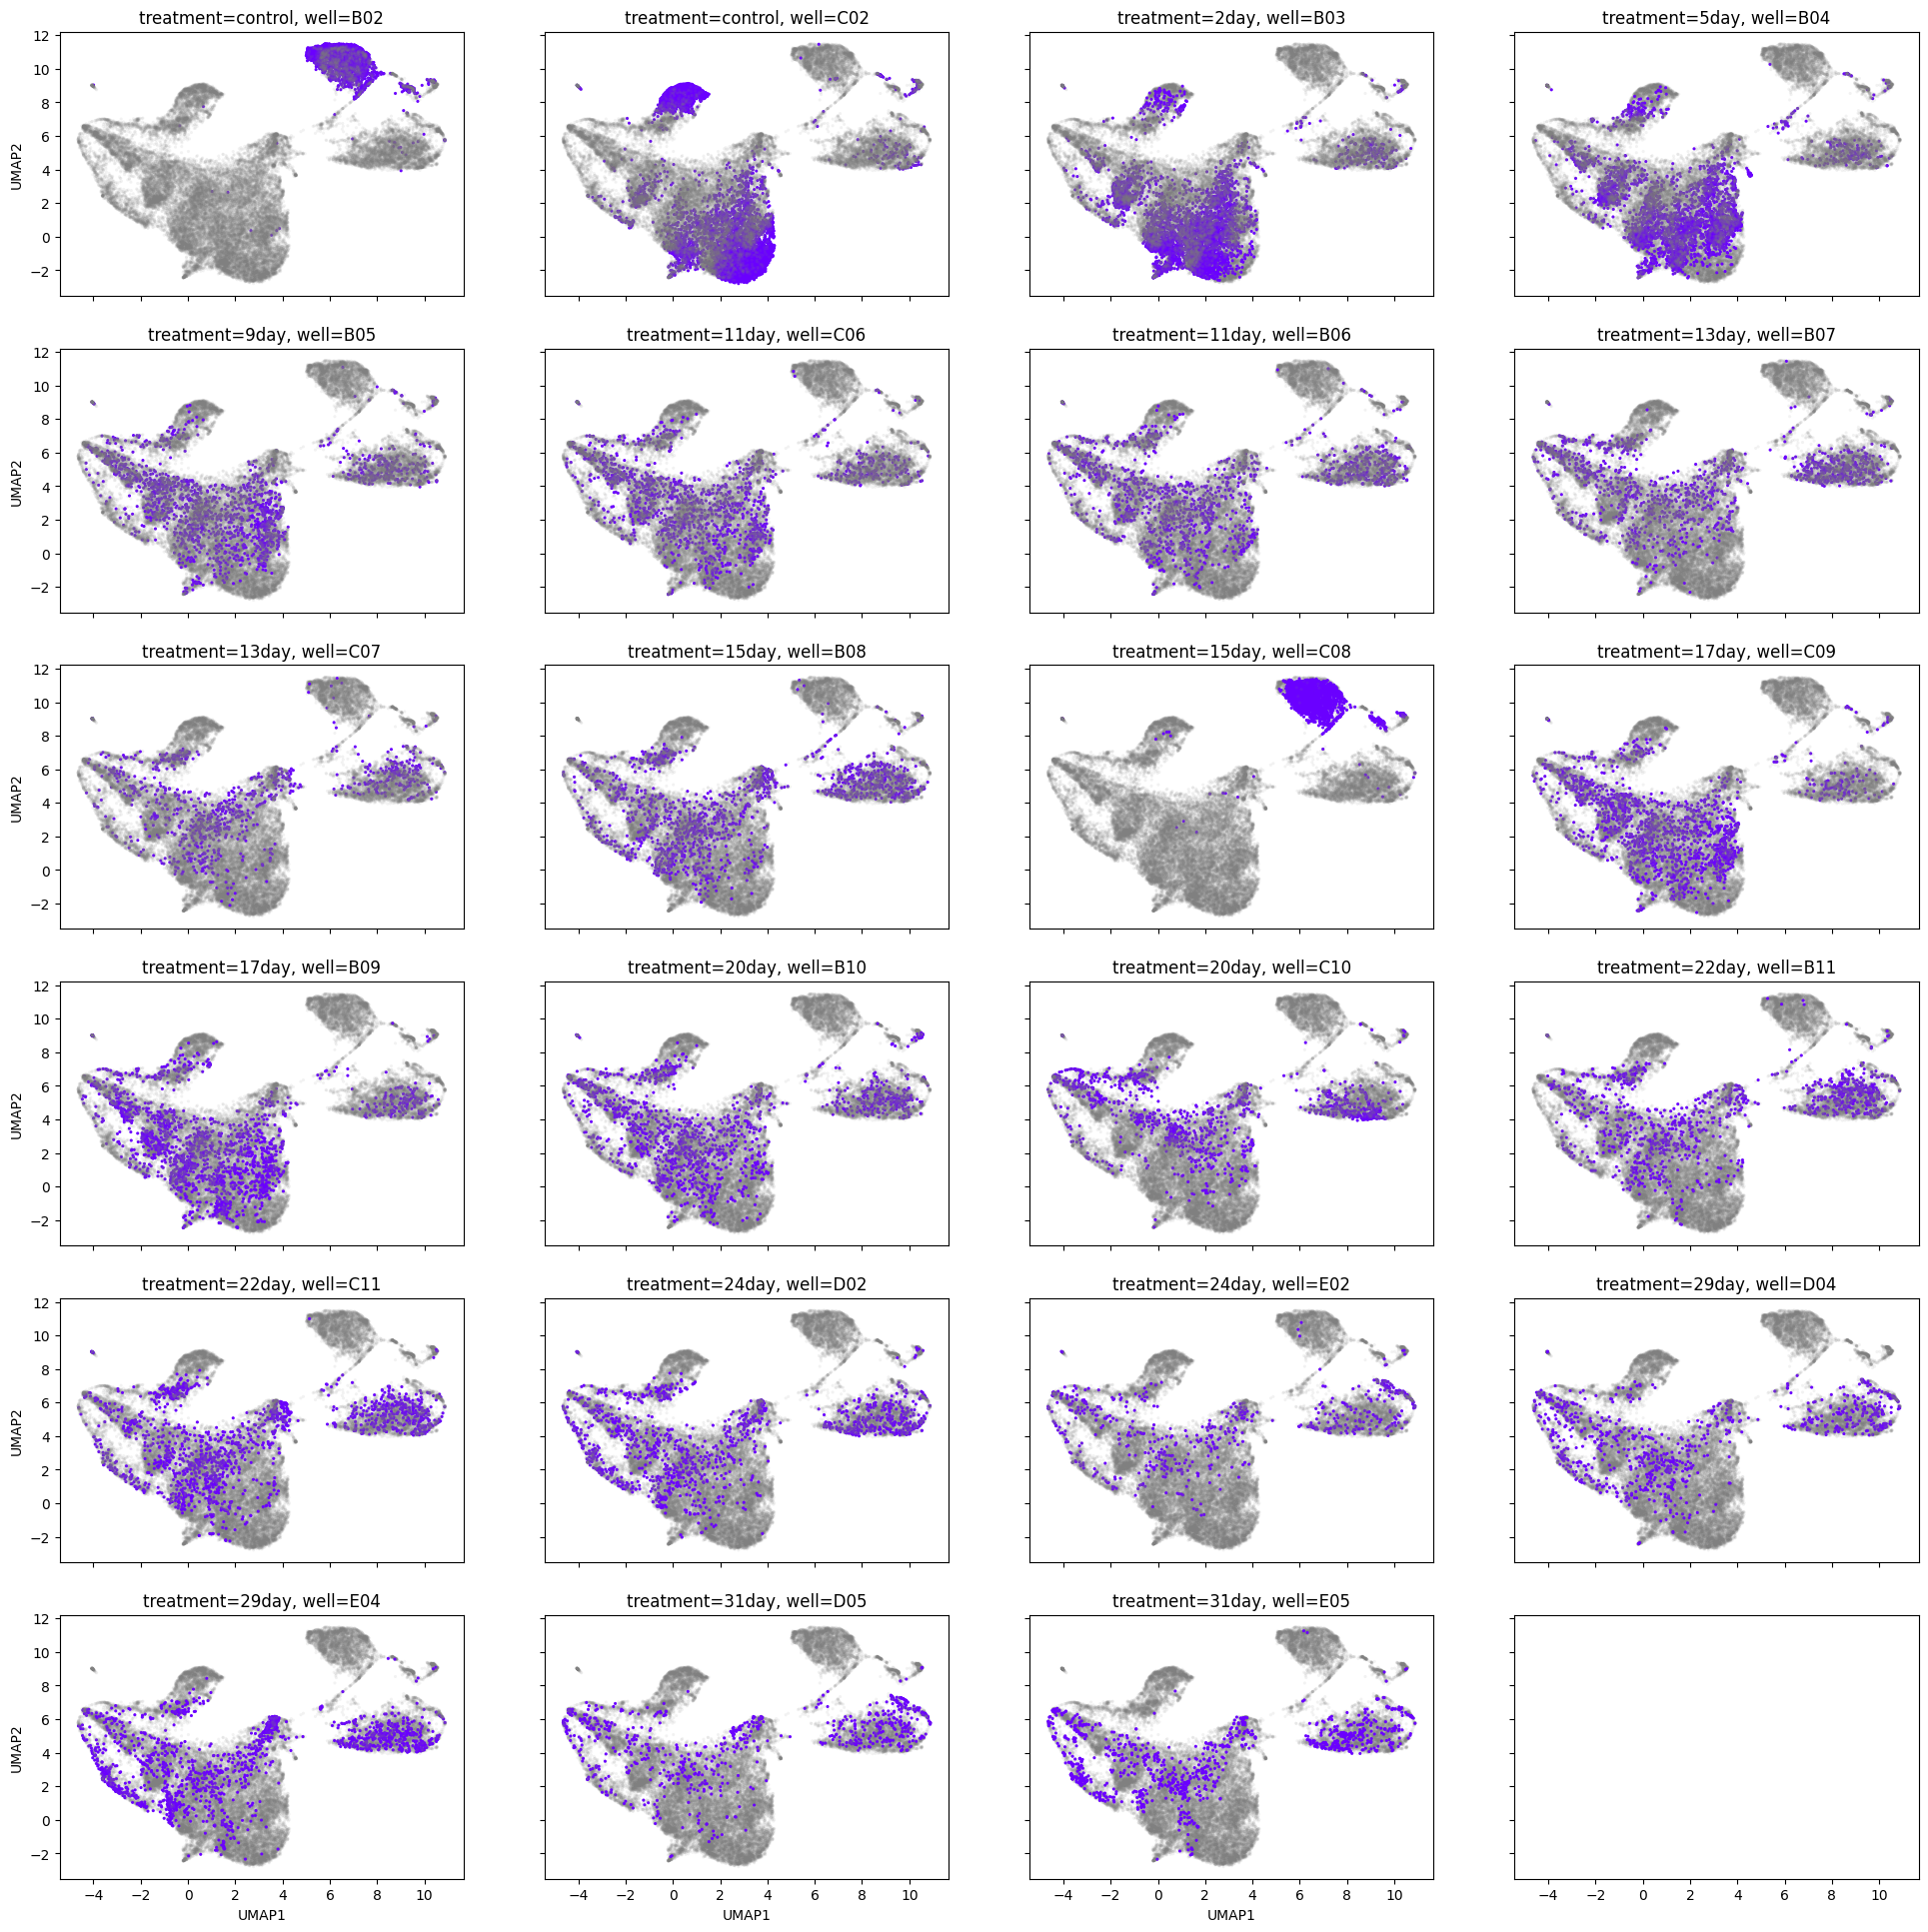

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(24, 24), sharex=True, sharey=True)
axes = axes.flatten()

plot_meta = cell_meta \
    .groupby(["well", "treatment_id", "treatment"]) \
    .size() \
    .reset_index(name='cell_count') \
    .sort_values("treatment_id") \
    [["well", "treatment", "cell_count"]]

for i, col in enumerate(plot_meta["well"]):
    axes.flatten()
    palette = [to_rgba("#808080", alpha=0.1)] * len(well_palette)
    palette[i] = to_rgba("#6A00FF", alpha=1)
    sns.scatterplot(data=embedding_final, x='UMAP1', y='UMAP2', hue='well',
                    palette=palette, linewidth=0, ax=axes[i], s=5, legend=False)
    axes[i].set_title(f'treatment={plot_meta["treatment"].iloc[i]}, well={plot_meta["well"].iloc[i]}')

There seem to be significant batch associations per the UMAP plot, specifically within certain treatment conditions.

## PCA

We will now also do PCA on the full dataset and check the association with treatment by fitting a linear model to the PC's and checking their $R^2$ with well ID.

In [10]:
assert(len(cell_meta)) == data.shape[0]

pca = PCA(n_components=50)
pcs = pca.fit_transform(data)

df = pd.DataFrame(pcs[:, :10], columns=[f"PC{k+1}" for k in range(10)])
df["well"] = cell_meta["well"].astype("category")

for i in range(10):
    res = smf.ols(f"PC{i+1} ~ C(well)", data=df).fit()
    print(f"PC{i+1} - R2 for well: {res.rsquared:.3f}") 

PC1 - R2 for well: 0.134
PC2 - R2 for well: 0.350
PC3 - R2 for well: 0.147
PC4 - R2 for well: 0.185
PC5 - R2 for well: 0.223
PC6 - R2 for well: 0.027
PC7 - R2 for well: 0.138
PC8 - R2 for well: 0.028
PC9 - R2 for well: 0.071
PC10 - R2 for well: 0.108


Again, the PCA analysis shows strong batch effects (PC2 explains over 33% of the variance between batches). There is a clear signal of batch-associated variance. However, the batch effect isn't overwhelming and this indicates that some biological signal is still recoverable.

## Statistical Tests for Batch Association

Here we will statistically quantify batch mixing via various methods.

### k-Nearset Neighbor Batch Effect Test (kBET)

Starting with kBET, we will perform class-conditional kBET to assess batch mixing within each treatment condition. Specifically, this will test batch mixing *within each treatment condition* (e.g., control, 2day. 12day, etc.) to ensure that this checks only for unwanted batch effects and not real biological differences. A high value for the rejection rate indicates a strong batch effect.

In [54]:
def build_knn_results(X, k=30, metric="euclidean", n_jobs=-1):
    """
    Returns a scib_metrics.nearest_neighbors.NeighborsResults
    with uniform k neighbors (no self), ready for kBET/iLISI.
    """
    # +1 so we can drop self if it appears as the first neighbor
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, n_jobs=n_jobs)
    nn.fit(X)
    dists, idx = nn.kneighbors(X)
    # Drop exact self-neighbor if present
    if (idx[:, 0] == np.arange(idx.shape[0])).all():
        idx = idx[:, 1:]
        dists = dists[:, 1:]
    else:
        # If self isn't in col 0 (rare), ensure we still return k neighbors
        idx = idx[:, :k]
        dists = dists[:, :k]
    return sm.nearest_neighbors.NeighborsResults(
        indices=idx.astype(np.int64, copy=False),
        distances=dists.astype(np.float32, copy=False),
    )

In [62]:
adata = ad.AnnData(
    X=data.values.astype(np.float32),
    obs=cell_meta.copy(),
    var=pd.DataFrame(index=data.columns),
)

adata.obsm["X_pca"] = pcs
X = adata.obsm["X_pca"]
k=30

Xnn = build_knn_results(adata.obsm["X_pca"], k=k, metric='euclidean', n_jobs=-1)

batches = adata.obs["well"].to_numpy()
treatments = adata.obs["treatment"].to_numpy()

# kBET
kbet_overall, stat_mean, pval_mean = sm.kbet(Xnn, batches)
kbet_score, kbet_df = sm.kbet_per_label(Xnn, batches, labels=treatments, return_df=True)

print(f"kBET (overall acceptance rate): {float(kbet_overall)}")
print(f"kBET (per-treatment mean): {float(kbet_score)}")

INFO     2day consists of a single batch or is too small. Skip.                                                    
INFO     5day consists of a single batch or is too small. Skip.                                                    
INFO     9day consists of a single batch or is too small. Skip.                                                    
kBET (overall acceptance rate): 0.020545063575168287
kBET (per-treatment mean): 0.5389374712907323


Again, kBET shows evidence of a moderate batch effect. The per-treatment mean is close to around ~0.54 which indicates moderate (but not complete) batch mixing.

### Modified Average Sillhouette Width (ASW) of Batch

This metric measures the silhoutte of a given batch. A score of 0 indicates perfect overlap of batches and a higher score means more batch effects.

In [58]:
asw_treat = float(sm.silhouette_label(
    adata.obsm["X_pca"],
    adata.obs["treatment"],
    rescale=True))

asw_batch_within_treat = float(
    sm.silhouette_batch(
        adata.obsm["X_pca"],
        adata.obs["treatment"],
        adata.obs["well"],
        rescale=True
    )
)

print(f"ASW (treatment): {asw_treat}")
print(f"ASW (batch within treatment): {asw_batch_within_treat}")

ASW (treatment): 0.4598062336444855
ASW (batch within treatment): 0.9607256650924683


ASW (treatment) shows the biological grouping. The higher the score the more well-separated the biological groups. Here we don't expect a high degree of separation so ~0.45 makes sense. For Batch ASW, this is adapted to assess batch mixing within each group. Here, surprisingly, ASW shows good mixing. This seems to contradict the kBET result, but when we consider the fact that ASW considers *global distances* while kBET considers *local distances*, we understand why. We don't expect highly distinct clusters in this dataset, even without batch effects (which explains why ASW (treatment) is ~0.46) so the global structure is intermixed between batches. If batches lie close together but do not intermix locally, ASW_batch can be high while kBET stays low. 

### Integrated Local Inverse Simpson's Index (iLISI)

iLISI is a measure of the diveristy of batch labels within a local region. Essentially, the more diverse batch labels in the neighborhood of a cell, the better the mixing. 

In [66]:
# Convert from CONNECTIVITIES, not distances
# Overall iLISI using the same Xnn
ilisi_per_cell = sm.ilisi_knn(Xnn, batches, scale=True)
adata.obs["iLISI"] = ilisi_per_cell
print(f"iLISI (mean, scaled): {np.nanmean(ilisi_per_cell):.4f}")

# Per-treatment: rebuild kNN on each subset's PCA embedding
ilisi_by_treat = {}
for t in adata.obs["treatment"].astype("category").cat.categories:
    mask = (adata.obs["treatment"] == t).to_numpy()
    if adata.obs.loc[mask, "well"].nunique() < 2:
        ilisi_by_treat[t] = np.nan
        continue

    Xi = X[mask]
    Xnn_sub = build_knn_results(Xi, k=k, metric="euclidean", n_jobs=-1)

    sub_batches = adata.obs.loc[mask, "well"].to_numpy()
    ilisi_by_treat[t] = float(np.nanmean(sm.ilisi_knn(Xnn_sub, sub_batches, scale=True)))

ilisi_by_treat


iLISI (mean, scaled): 0.0642


{'11day': 0.5341585874557495,
 '13day': 0.3815959692001343,
 '15day': 0.48732805252075195,
 '17day': 0.2619667053222656,
 '20day': 0.5622427463531494,
 '22day': 0.7136802673339844,
 '24day': 0.5211236476898193,
 '29day': 0.5958888530731201,
 '2day': nan,
 '31day': 0.26290440559387207,
 '5day': nan,
 '9day': nan,
 'control': 0.1372278928756714}

## KMeans Clustering

### Elbow Plot

In [ ]:
nclust = range(2,30)
interias = []

kmeans_results = pd.DataFrame(index=data.index)

for i in nclust:
    kmeans = KMeans(n_clusters=i, random_state=416, n_init=10)
    kmeans.fit(data)
    
    # Store inertia for elbow plot
    interias.append(kmeans.inertia_)
    
    # Add cluster labels as a new col
    kmeans_results[f'kmeans_{i}clust'] = kmeans.labels_


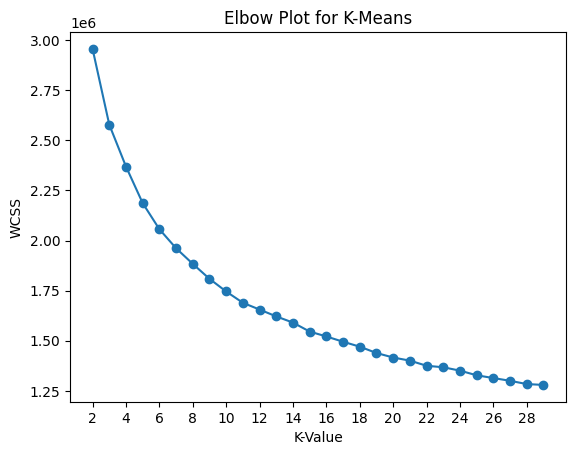

In [ ]:
plt.plot(nclust, interias, marker='o')
plt.title('Elbow Plot for K-Means')
plt.xticks(np.arange(2, 30, 2))
plt.xlabel('K-Value')
plt.ylabel('WCSS')
plt.show()

So K-Means does not look like it's the best method of clustering available for this dataset. 